In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ipywidgets import interact, IntSlider, FloatSlider

%matplotlib inline


In [217]:
df_train = pd.read_csv('train.csv', sep=',', encoding='utf8',index_col = '_id')

In [219]:
df_subm = pd.read_csv('sample_submission.csv', sep=',', encoding='utf8',index_col = '_id')
df_test = pd.read_csv('test.csv', sep=',', encoding='utf8',index_col = '_id')

In [220]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

job
{'services', 'unemployed', 'student', 'retired', 'self-employed', 'blue-collar', 'admin.', 'housemaid', 'unknown', 'management', 'entrepreneur', 'technician'}


marital
{'single', 'divorced', 'married', 'unknown'}


education
{'basic.4y', 'university.degree', 'basic.6y', 'unknown', 'illiterate', 'basic.9y', 'high.school', 'professional.course'}


default
{'yes', 'no', 'unknown'}


housing
{'yes', 'unknown', 'no'}


loan
{'yes', 'unknown', 'no'}


contact
{'telephone', 'cellular'}


month
{'may', 'sep', 'apr', 'aug', 'jul', 'nov', 'jun', 'oct', 'mar', 'dec'}


day_of_week
{'tue', 'mon', 'fri', 'thu', 'wed'}


poutcome
{'failure', 'nonexistent', 'success'}




In [222]:
# Функция для подсчета недостающих столбцов
def missing_values_table(df):
    
        # Всего недостает
        mis_val = df.isnull().sum()
        
        # Процент недостающих данных
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка про процентажу
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Инфо
        print ("В выбранном датафрейме " + str(df.shape[1]) + " столбцов.\n"      
            "Всего " + str(mis_val_table_ren_columns.shape[0]) +
              " столбцов с неполными данными.")
        
        # Возврат таблицы с данными
        return mis_val_table_ren_columns
    
missing_values = missing_values_table(df_train)
missing_values.head(10)

В выбранном датафрейме 21 столбцов.
Всего 0 столбцов с неполными данными.


,Missing Values,% of Total Values


Text(0.5,0,'Столбцы')

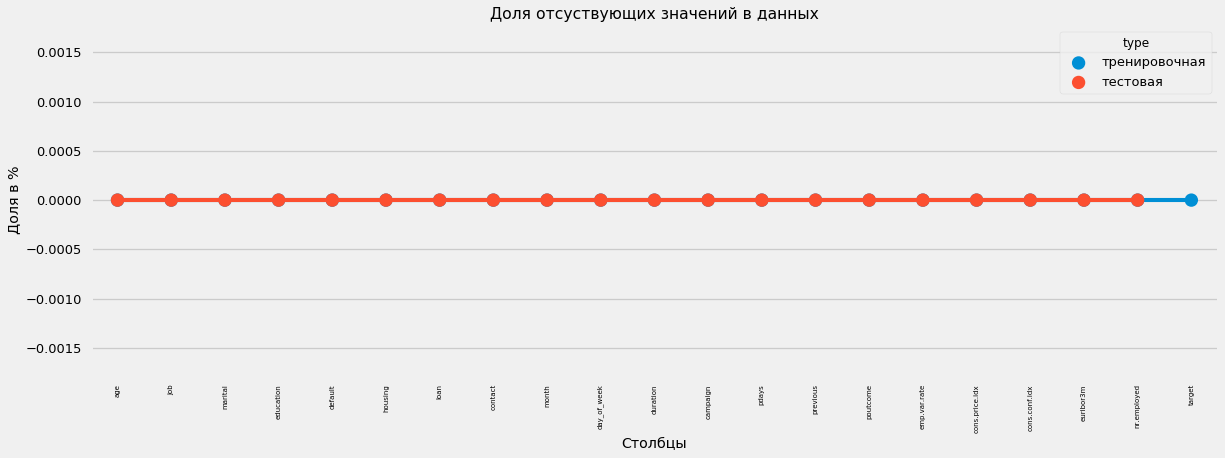

In [223]:
plt.style.use('seaborn-talk')

fig = plt.figure(figsize=(18,6))
miss_train = pd.DataFrame((df_train.isnull().sum())*100/df_train.shape[0]).reset_index()
miss_test = pd.DataFrame((df_test.isnull().sum())*100/df_test.shape[0]).reset_index()
miss_train["type"] = "тренировочная"
miss_test["type"]  =  "тестовая"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="type")
plt.xticks(rotation =90,fontsize =7)
plt.title("Доля отсуствующих значений в данных")
plt.ylabel("Доля в %")
plt.xlabel("Столбцы")

In [224]:
# варианты значений типа Object
df_train.select_dtypes(include=[object]).apply(pd.Series.nunique, axis = 0)


job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [225]:
df_train.target.value_counts()

0    21925
1     2787
Name: target, dtype: int64

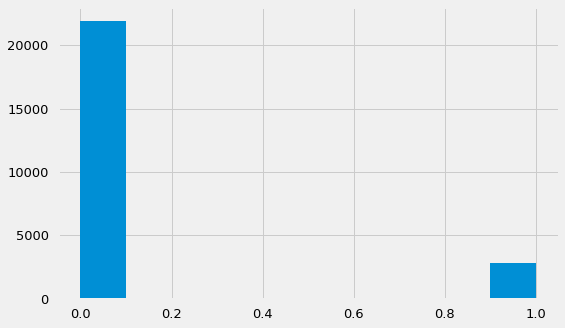

In [226]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]

plt.hist(df_train.target)
plt.show()

In [227]:
# Добавляет в DataFrame df новый столбец с именем column_name+'_le', содержащий номера категорий, 
# соответствующие столбцу column_name. Исходный столбец column_name удаляется
#
def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

# Кодирование с использованием ранее созданного LabelEncoder
#
def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

# Вначале кодирует столбец column_name при помощи LabelEncoder, потом добавляет в DataFrame df новые столбцы 
# с именами column_name=<категория_i>. Столбцы column_name и column_name+'_le' удаляются
# Usage: df, label_encoder = encode_with_OneHotEncoder_and_delete_column(df, column_name)
#
def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

# То же, что предыдущий метод, но при помощи уже существующего LabelEncoder
#
def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

# Реализует Dummy-кодирование
#
def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [228]:
def extract_XY(data):
    X = data.drop(['target'], axis=1)
    Y = data['target']
    return X, Y

X, Y = extract_XY(df_train)

print (X.shape, Y.shape)

(24712, 20) (24712,)


In [229]:
X1 = X.copy()

In [230]:
Y1 = Y.copy()

In [231]:
def OneHotEncoder_le(df,column_le):
    df_out = df.copy()
    ohe = OneHotEncoder(sparse=False)
    new_ohe_features = ohe.fit_transform(df_out[column_le].values.reshape(-1,1))
    
    tmp = pd.DataFrame(new_ohe_features, columns=['job='+str(i) for i in range(new_ohe_features.shape[1])])
    df_out = pd.concat([df_out,tmp], axis=1)

    return df_out

In [232]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    
    # month - последний контактный месяц года ("jan", "feb", "mar", ..., "nov", "dec") 
    
   
    df_output['is_month_occurs'] = df_output['month'].map(lambda x: 0 if x == 'unknown' else 1)
    
    max_mths_month = np.nanmax(df_output.month.values)
    df_output['month'].fillna(max_mths_month, inplace=True)
    
  
    
    
    df_output['is_job_occurs'] = df_output['job'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_marital_occurs'] = df_output['marital'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_education_occurs'] = df_output['education'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_default_occurs'] = df_output['default'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_housing_occurs'] = df_output['housing'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_loan_occurs'] = df_output['loan'].map(lambda x: 0 if x == 'unknown' else 1)
    

        
    #id_le = encode_with_LabelEncoder(df_output,'_id')
    job_le = encode_with_LabelEncoder(df_output,'job')
    marital_le = encode_with_LabelEncoder(df_output,'marital')
    education_le = encode_with_LabelEncoder(df_output,'education')
    default_le = encode_with_LabelEncoder(df_output,'default')
    housing_le = encode_with_LabelEncoder(df_output,'housing')
    loan = encode_with_LabelEncoder(df_output,'loan')
    contact_le = encode_with_LabelEncoder(df_output,'contact')
    month_le = encode_with_LabelEncoder(df_output,'month')
    day_of_week_le = encode_with_LabelEncoder(df_output,'day_of_week')
    poutcome_le = encode_with_LabelEncoder(df_output,'poutcome')
    
  
    
    return df_output

In [233]:
def preproc_data_oneh(df_input):
    df_output = df_input.copy()
    
    
    # month - последний контактный месяц года ("jan", "feb", "mar", ..., "nov", "dec") 
    
   
    df_output['is_month_occurs'] = df_output['month'].map(lambda x: 0 if x == 'unknown' else 1)
    
    max_mths_month = np.nanmax(df_output.month.values)
    df_output['month'].fillna(max_mths_month, inplace=True)
    
  
    
    
    df_output['is_job_occurs'] = df_output['job'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_marital_occurs'] = df_output['marital'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_education_occurs'] = df_output['education'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_default_occurs'] = df_output['default'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_housing_occurs'] = df_output['housing'].map(lambda x: 0 if x == 'unknown' else 1)
    df_output['is_loan_occurs'] = df_output['loan'].map(lambda x: 0 if x == 'unknown' else 1)
    

    #id_le = encode_with_LabelEncoder(df_output,'_id')
    job_le = encode_with_LabelEncoder(df_output,'job')
    marital_le = encode_with_LabelEncoder(df_output,'marital')
    education_le = encode_with_LabelEncoder(df_output,'education')
    default_le = encode_with_LabelEncoder(df_output,'default')
    housing_le = encode_with_LabelEncoder(df_output,'housing')
    loan = encode_with_LabelEncoder(df_output,'loan')
    contact_le = encode_with_LabelEncoder(df_output,'contact')
    month_le = encode_with_LabelEncoder(df_output,'month')
    day_of_week_le = encode_with_LabelEncoder(df_output,'day_of_week')
    poutcome_le = encode_with_LabelEncoder(df_output,'poutcome')
        
   
    
    df_output = OneHotEncoder_le(df_output,'job_le')
    df_output = OneHotEncoder_le(df_output,'marital_le')
    df_output = OneHotEncoder_le(df_output,'education_le')
    df_output = OneHotEncoder_le(df_output,'default_le')
    df_output = OneHotEncoder_le(df_output,'housing_le')
    df_output = OneHotEncoder_le(df_output,'loan_le')
    df_output = OneHotEncoder_le(df_output,'contact_le')
    df_output = OneHotEncoder_le(df_output,'month_le')
    df_output = OneHotEncoder_le(df_output,'day_of_week_le')
    df_output = OneHotEncoder_le(df_output,'poutcome_le')
    
    
    
    return df_output

In [234]:
df_preproc = X1.pipe(preproc_data)

In [208]:
# Если OneHold то хуже получается
#df_preproc = X1.pipe(preproc_data_oneh)

In [236]:
df_preproc.shape

(24712, 27)

In [237]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_preproc, Y1, test_size=0.33, random_state=42)

In [238]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Your Code Here


model_LR = LogisticRegression(penalty='l2', C=1)                     # инициализируем модель
model_LR.fit(X_train, y_train)                      # обучаем модель на трейн данных и тест данных
predict_LR = model_LR.predict(X_test)                  # делаем предсказание
predict_proba_LR = model_LR.predict_proba(X_test)      # вероятность

print('precision LR', precision_score(y_test, predict_LR))
print('recall LR', recall_score(y_test, predict_LR))
print('accuracy LR', accuracy_score(y_test, predict_LR))

precision LR 0.6767485822306238
recall LR 0.387027027027027
accuracy LR 0.9095033721643163


In [239]:
model_RF = RandomForestClassifier(n_estimators=10000,max_depth = 100,criterion='entropy',n_jobs=-1)
model_RF.fit(X_train, y_train)
predict_RF = model_RF.predict(X_test)
predict_proba_RF = model_RF.predict_proba(X_test)

print('precision RF', precision_score(y_test, predict_RF))
print('recall RF', recall_score(y_test, predict_RF))
print('accuracy RF', accuracy_score(y_test, predict_RF))

precision RF 0.6564774381368268
recall RF 0.4875675675675676
accuracy RF 0.9129368485591661


In [240]:
model_DT = DecisionTreeClassifier(criterion='entropy', random_state=1000)
model_DT.fit(X_train, y_train)
predict_DT = model_DT.predict(X_test)
predict_proba_DT = model_DT.predict_proba(X_test)

print('precision DT', precision_score(y_test, predict_DT))
print('recall DT', recall_score(y_test, predict_DT))
print('accuracy DT', accuracy_score(y_test, predict_DT))

precision DT 0.5301724137931034
recall DT 0.5318918918918919
accuracy DT 0.8934396076026977


(-0.01, 1.01)

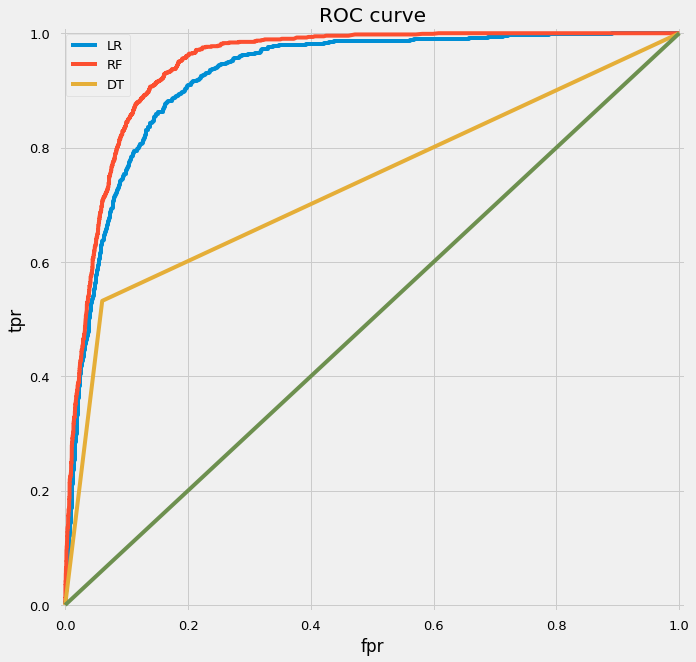

In [241]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr_LR, tpr_LR, thresholds = roc_curve(y_test, predict_proba_LR[:,1]) #вложили реальные Y  и предугаданные
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, predict_proba_RF[:,1]) #вложили реальные Y  и предугаданные
fpr_DT, tpr_DT, thresholds = roc_curve(y_test, predict_proba_DT[:,1]) #вложили реальные Y  и предугаданные
plt.figure(figsize=(10, 10))
plt.plot(fpr_LR, tpr_LR,label='LR')
plt.plot(fpr_RF, tpr_RF,label='RF')
plt.plot(fpr_DT, tpr_DT,label='DT')
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.legend()
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [242]:
roc_auc_score(y_test, predict_proba_LR[:,1])

0.9236520503906398

In [ ]:
0.9393011102388695  100
0.9402795409517402   max_depth = 100

0.9437503644723562 n_estimators=1000,max_depth = 100
0.9441728533512767 n_estimators=10000,max_depth = 100
0.9460879967104032 n_estimators=10000,max_depth = 100,criterion='entropy'
0.9457896153414826 n_estimators=10000,max_depth = 1000,criterion='entropy',n_jobs=-1
0.9457603080258681 n_estimators=10000,max_depth = 500,criterion='entropy',n_jobs=-1
0.9456229673657061 n_estimators=10000,max_depth = 50,criterion='entropy',n_jobs=-1

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [244]:
model = Pipeline([('scaler', StandardScaler()),('knn', KNeighborsClassifier(n_neighbors=5))])

In [245]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [246]:
y_hat = model.predict(X_test)

In [247]:
y_hat_proba = model.predict_proba(X_test, )

In [248]:
roc_auc_score(y_test, y_hat_proba[:, 1])

0.8519963365855482

In [260]:
scores_test = []
scores_train = []

for k in range(1, 15):  # k кол-во ближайших соседей для каждого K y
    model = Pipeline([
       ('scaler', StandardScaler()),
       ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train, )

    y_hat_test = model.predict_proba(X_test)
    scores_test.append(roc_auc_score(y_test, y_hat_test[:, 1]))

    y_hat_train = model.predict_proba(X_train)
    scores_train.append(roc_auc_score(y_train, y_hat_train[:, 1]))# Your Code Here  

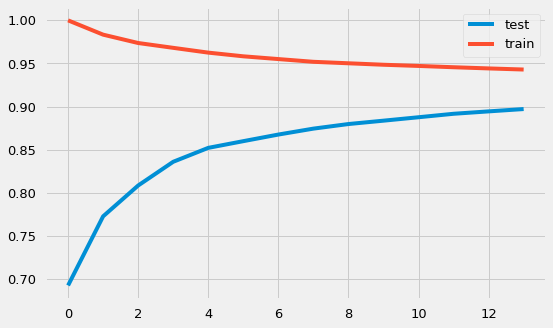

In [261]:
plt.plot(scores_test, label='test')
plt.plot(scores_train, label='train')
plt.legend()

In [250]:
df_preproc_test = df_test.pipe(preproc_data)

In [252]:
df_preproc_test.head().T

_id,66810d8e6bf2b41c880a7bc6c8a1e295,ccac3879652b08cb8b44c1920fd93afa,fcccab4d7a76f70647f015f2c84c2af8,ed8399278c30678dab739045fa12b440,1d4d62ac5cabcb48bac7112813f290cb
age,57.000,55.000,33.000,36.000,27.000
duration,371.000,285.000,52.000,355.000,189.000
campaign,1.000,2.000,1.000,4.000,2.000
pdays,999.000,999.000,999.000,999.000,999.000
previous,1.000,0.000,1.000,0.000,0.000
emp.var.rate,-1.800,1.100,-1.800,1.400,1.400
cons.price.idx,92.893,93.994,92.893,94.465,93.918
cons.conf.idx,-46.200,-36.400,-46.200,-41.800,-42.700
euribor3m,1.299,4.860,1.313,4.967,4.963
nr.employed,5099.100,5191.000,5099.100,5228.100,5228.100


In [251]:
df_preproc_test.shape

(16476, 27)

In [253]:

log_reg_pred = model_RF.predict_proba(df_preproc_test)[:, 1]

In [254]:
log_reg_pred

array([0.1279, 0.0039, 0.0003, ..., 0.0089, 0.0027, 0.0006])

In [256]:
result = pd.DataFrame(np.array(log_reg_pred), columns=['target'], index=df_preproc_test.index)

print (result[result['target']>0.5].count())
print (result.count())

target    1410
dtype: int64
target    16476
dtype: int64


In [259]:
result.to_csv('sample_submission.csv', encoding='utf8')